In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state, 
                          stommel_arons_forcing, run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# --- Stommel–Arons source (NE) + uniform sink (zero net flux) ---

Nx, Ny = 128, 128
Lx, Ly = 2.0e6, 2.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

# Beta-plane + weak Rayleigh to allow a western boundary current–like response
params = ModelParams(H=1000.0, g=9.81, rho=1025.0,
                     f0=1e-4, beta=2e-11, y0=Ly/2,
                     r=1/(50*86400),     # ~50-day e-fold; adjust as you like
                     linear=True)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 30 * 86400.0      # ~30 days to see large-scale adjustment

# Start from rest
ic_fn = lambda g, p: setup_initial_state(g, p, mode='rest')

# Point source (NE), uniform sink; ramp in over 2 days to avoid a shock
forcing_fn = lambda t, g, p: stommel_arons_forcing(
    t, g, p,
    Q0=2e-8,       # ~2 cm/day vertical velocity at the source peak
    R=1.5e5,       # ~150 km source radius
    x0=0.95*Lx, y0=0.95*Ly,
    time_ramp=2*86400
)

# Save η,u,v for diagnostics/plots
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=120, out_vars=("eta","u","v"))

print('Saved steps:', len(out['time']))


Saved steps: 274


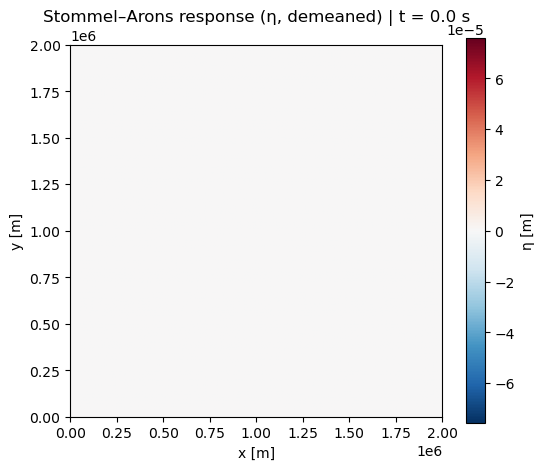

In [3]:
from shallowwater.visualize import animate_eta

# mean-removed RdBu with contours
anim = animate_eta(out, grid, interval=120, contours=True, contour_levels=21,
                   title="Stommel–Arons response (η, demeaned)")

In [4]:
# GIF (no external dependencies)
anim.save("eta_05.gif", fps=10)

# MP4 (requires ffmpeg available on your PATH)
# anim.save("eta.mp4", fps=20)

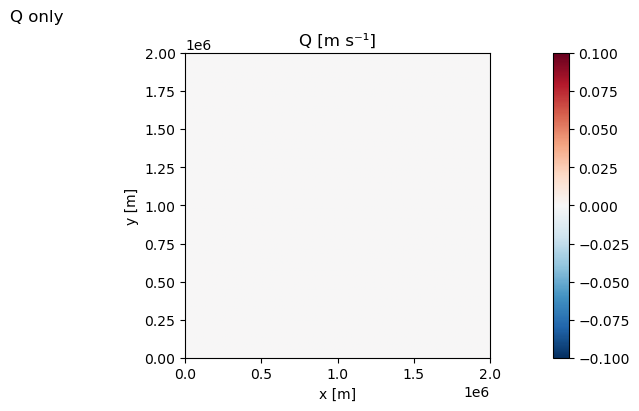

In [5]:
from shallowwater.visualize import plot_forcings

fig_tx = plot_forcings(forcing_fn, t=0.0, grid=grid, params=params, what="Q",
                       title="Q only")

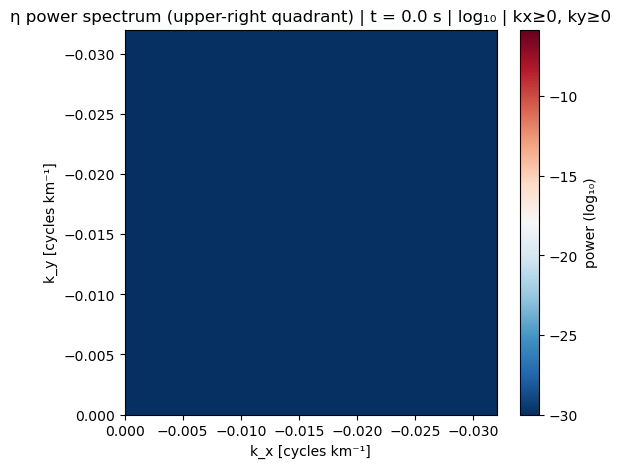

In [6]:
from shallowwater.visualize import animate_eta_spectrum

spec = animate_eta_spectrum(out, grid, quadrant="ur", log10=True, interval=80,
                            title="η power spectrum (upper-right quadrant)")
# spec  # displays inline
# spec.save("eta_spectrum_ur.gif", fps=20)


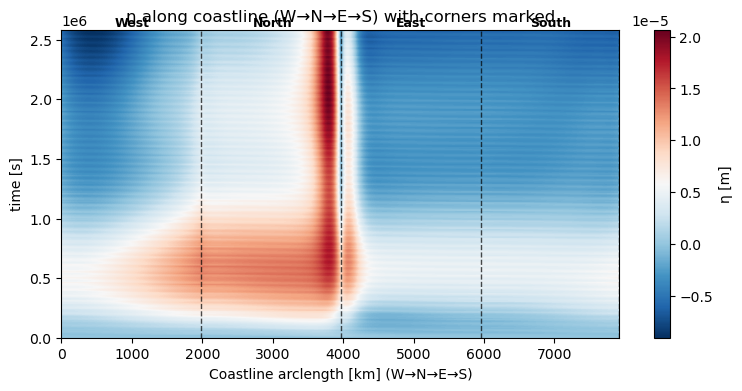

In [7]:
from shallowwater.visualize import coast_hovmoller

fig = coast_hovmoller(out, grid, units_x="km",
                      title="η along coastline (W→N→E→S) with corners marked")